In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import torch
from torch.utils.data import Dataset

In [40]:
# parameters
coords_voltages = '../coords_voltages/coords_voltages_C0016.mat'
square_size = 1.6

data = scipy.io.loadmat(coords_voltages)
points = np.flip(data['coords'][0:625, 0:2], axis=1)
voltage = data['voltages']
points = -points * 0.01 * square_size

In [41]:
class MyData(Dataset):
    def __init__(self, coordiantes, voltage):
        self.coordinates = coordiantes
        self.voltage = voltage

    def __getitem__(self, idx): 

        return self.coordinates[idx], self.voltage[idx]

    def __len__(self):
        return self.voltage.shape[0]

In [42]:
class Model(torch.nn.Module):
    
 
    def __init__(self,num_i,num_h,num_o):
        super(Model,self).__init__()
        
        self.linear1=torch.nn.Linear(num_i,num_h)
        self.tanh1=torch.nn.Tanh()
        self.linear2=torch.nn.Linear(num_h,num_h)
        self.tanh2=torch.nn.Tanh()
        self.linear3=torch.nn.Linear(num_h,num_h)
        self.tanh3=torch.nn.Tanh()
        self.linear4=torch.nn.Linear(num_h,num_h)
        self.tanh4=torch.nn.Tanh()
        self.linear5=torch.nn.Linear(num_h,num_h)
        self.tanh5=torch.nn.Tanh()
        self.linear6=torch.nn.Linear(num_h,num_o)
  
    def forward(self, x):
        x = self.linear1(x)
        x = self.tanh1(x)
        x = self.linear2(x)
        x = self.tanh2(x)
        x = self.linear3(x)
        x = self.tanh3(x)
        x = self.linear4(x)
        x = self.tanh4(x)
        x = self.linear5(x)
        x = self.tanh5(x)
        x = self.linear6(x)

        return x

In [43]:
data_train = MyData(points, voltage)

data_loader_train = torch.utils.data.DataLoader(dataset = data_train,
                                                batch_size = 32,
                                                shuffle = True)

In [44]:
model = Model(2,7,2)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 5000

for epoch in range(epochs) :
    sum_loss=0
    train_correct=0

    for data in data_loader_train:
        inputs, labels = data # inputs: [100,3]
        inputs_new = torch.tensor(inputs, dtype=torch.float32)
        labels_new = torch.tensor(labels, dtype=torch.float32)
        outputs=model(inputs_new) #outputs: [100,2]

        optimizer.zero_grad()
        loss = loss_function(outputs,labels_new)
        loss.backward()
        optimizer.step()
        sum_loss += loss.item()
    if epoch % 1000 == 0:
        print('epoch: {}, loss: {}'.format(epoch, sum_loss))

model.train()

/var/folders/dp/_xrz74d50vgb_z54bv1pbcrm0000gn/T/ipykernel_31578/1111618223.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs_new = torch.tensor(inputs, dtype=torch.float32)
/var/folders/dp/_xrz74d50vgb_z54bv1pbcrm0000gn/T/ipykernel_31578/1111618223.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_new = torch.tensor(labels, dtype=torch.float32)


epoch: 0, loss: 48.06255507469177
epoch: 1000, loss: 0.002436579732602695
epoch: 2000, loss: 0.0006306353016043431
epoch: 3000, loss: 0.0009779391039046459
epoch: 4000, loss: 0.0009114850427067722


Model(
  (linear1): Linear(in_features=2, out_features=7, bias=True)
  (tanh1): Tanh()
  (linear2): Linear(in_features=7, out_features=7, bias=True)
  (tanh2): Tanh()
  (linear3): Linear(in_features=7, out_features=7, bias=True)
  (tanh3): Tanh()
  (linear4): Linear(in_features=7, out_features=7, bias=True)
  (tanh4): Tanh()
  (linear5): Linear(in_features=7, out_features=7, bias=True)
  (tanh5): Tanh()
  (linear6): Linear(in_features=7, out_features=2, bias=True)
)

<function matplotlib.pyplot.show(close=None, block=None)>

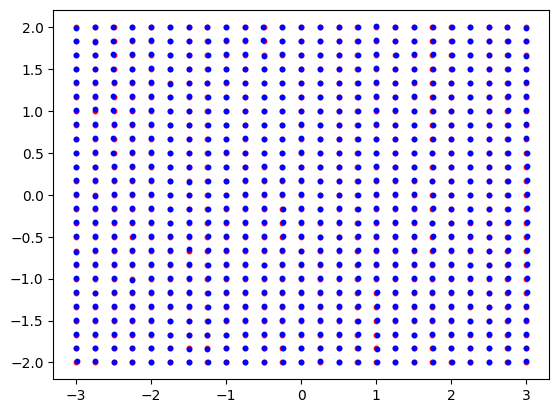

In [45]:
voltage_pre = model(torch.tensor(points, dtype = torch.float32))
voltage_pre = voltage_pre.detach().numpy()
plt.figure
for i in range(voltage.shape[0]):
    plt.scatter(voltage[i,0], voltage[i,1], c='r', s=10)
    plt.scatter(voltage_pre[i,0], voltage_pre[i,1], c='b', s=10)
plt.show

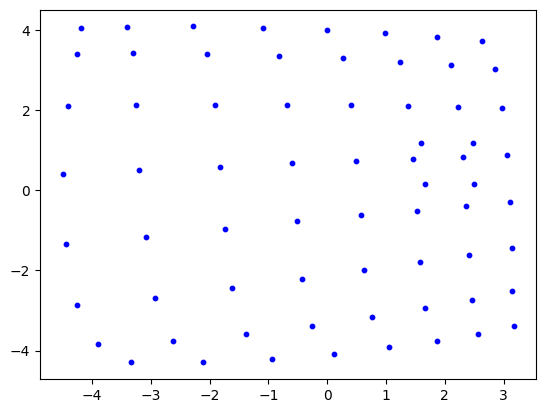

In [46]:

x_1 = -0.4  # scanning area
y_1 = -0.4
x_2 = 0.4
y_2 = 0.4
x_num = 8
y_num = 8

points_test = np.array([[-0.08472587,  0.0237499 ],
       [-0.08215396, -0.06787037],
       [ 0.03189364, -0.07475629],
       [ 0.03845021,  0.01968364]])
# center_points = np.array([-0.15, 0.15, 0]) # G1
center_index = np.where((np.abs(voltage[:, 0]) < 1e-4) * (np.abs(voltage[:, 1]) < 1e-4))[0]
center_point = points[center_index] # G2

# center_points = np.array([-0.13531 , -0.22760459,  0])
# center_points = np.array([-0.14531 , -0.22760459,  0])

[X,Y] = np.meshgrid(np.linspace(x_1, x_2, x_num), np.linspace(y_2, y_1, y_num), indexing='xy')
input_points = np.stack((X.reshape(-1), Y.reshape(-1)), axis = 1) + center_point.reshape(1,2)
infering_voltage_test = model(torch.tensor(points_test, dtype = torch.float32))
infering_voltage = model(torch.tensor(input_points, dtype = torch.float32))
infering_voltage = infering_voltage.detach().numpy()
infering_voltage_test = infering_voltage_test.detach().numpy()
plt.figure()
for i in range(len(infering_voltage)):
    plt.scatter(infering_voltage[i,0], infering_voltage[i,1], c='b', s=10)

for i in range(len(infering_voltage_test)):
    plt.scatter(infering_voltage_test[i,0], infering_voltage_test[i,1], c='b', s=10)
plt.show()

In [47]:
infering_voltage_test

array([[1.5913726 , 1.1912302 ],
       [1.6634995 , 0.15652788],
       [2.4908621 , 0.16325387],
       [2.482547  , 1.178259  ]], dtype=float32)